# Homework 2

## FINM 37500 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

In [1]:
import numpy as np
import pandas as pd

import sys
sys.path.insert(0, '../cmds')
from ficcvol import *
from binomial import *
from ratecurves import *

import datetime
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

# 1. Stripping Caps

The file `data/cap_curves_2024-02-16.xlsx` has market data on the following curves:
* swap rates (SOFR)
* discount factors
* forward rates 
* flat volatilites

A few details
* the swap and forward rates are quarterly compounded.
* the flat volatilites are (Black) quotes on caps containing caplets ranging from expiration of $\tau=.5$ to $\tau=T$.
* the details of the data prep can be found in `build_data/Process Cap Quotes`.

In [2]:
cap_curves = pd.read_excel('cap_curves_2024-02-16.xlsx', sheet_name='rate curves 2024-02-16', index_col=0)

## Context

Recall that 
* a cap is made of caplets with $.5\le \tau \le T$
* the flat volatility at $T$ is input for every caplet corresponding to the cap of $T$.
* use Black's formula for this calculation.
* in Black's formula, use $T-0.25$ as the rate for the caplet is determined one period before it is paid.

As for the cap parameters,
* the cap's strike is the swap rate with the same tenor. So the $T=2$ cap is struck at the swap rate of $\tau=2$.
* the notional of the cap is $100.
* the payoff of each caplet is

$$\frac{100}{n}\max(r-K,0)$$

where $n$ is the frequency; here $n=4$.

Thus, the corresponding value in Black's fomula for a caplet is
$$P^{\text{cap}}_{T} = \frac{100}{n} \sum_{\tau=.5}^T B_{\text{call}}(\overline{\sigma}_T, \tau-.25, K=s_T, f_{\tau}, Z_{\tau})$$
Note here that for every caplet in cap $T$, we plug in the same 
* flat vol with tenor $T$.
* strike which is the swap rate of maturity $T$.

The notation above is using subscripts for tenor / maturity rather than time period. That is, $Z_{\tau}$ denotes $Z(t, t+\tau)$ which is today's discount factor for maturity $\tau$. Similarly for the swap rate of tenor $T$, denoted above $s_T$ and forward rate $f(t,t+\tau-.25, t+\tau)$ denoted simply $f_{\tau}$.

### Black's Formula
Recall Black's formula:

$$\begin{align}
B_{\text{call}}(\sigma, T, K, f, Z) = &\; Z\left[f\mathcal{N}\left(d_1\right) - K\mathcal{N}(d_2)\right] \\
d_1 =& \frac{\ln\left(\frac{f}{K}\right) + \frac{\sigma^2}{2}T}{\sigma\sqrt{T}} \\
d_2 =& d_1 -\sigma\sqrt{T}
\end{align}
$$

## 1.1 Cap Prices

For each cap maturity, $.5\le T \le 10$, use the flat volatility to get the price of the cap.

Report the cap prices across expirations, $.5\le T \le 10$.

Plot the cap prices across expirations.

In [3]:
def flat_to_forward_vol(curves, freq=None, notional=100):
    """
    Converts flat volatilities to forward volatilities using caplet prices.
    
    Args:
        curves (DataFrame): DataFrame containing the input curves, including 'flat vols', 'swap rates', 'forwards', and 'discounts'.
        freq (int, optional): Frequency of the caplet payments. If not provided, it is calculated based on the time step of the input curves.
        notional (float, optional): Notional amount for the caplet payments.
    
    Returns:
        DataFrame: DataFrame containing the converted forward volatilities.
    """
    
    dt = curves.index[1] - curves.index[0]
    if freq is None:
        freq = int(1/dt)
   
    capcurves = curves[['flat vols']].copy()

    for tstep, t in enumerate(capcurves.index):
    
        if tstep == 0:
            capcurves.loc[t,'caplet prices'] = np.nan
            capcurves.loc[t,'fwd vols'] = np.nan
        else:
            capcurves.loc[t,'cap prices'] = cap_vol_to_price(capcurves.loc[t,'flat vols'], curves.loc[t,'swap rates'], curves.loc[:t,'forwards'], curves.loc[:t,'discounts'], dt=dt)
            capcurves['caplet prices'].loc[t] = capcurves.loc[t,'cap prices'] - capcurves.loc[:tprev,'caplet prices'].sum()
            wrapper = lambda vol: capcurves['caplet prices'].loc[t] - notional * (1/freq) * blacks_formula(tprev, vol, curves.loc[t,'swap rates'], curves.loc[t,'forwards'], curves.loc[t,'discounts'])
            capcurves.loc[t,'fwd vols'] = fsolve(wrapper,capcurves.loc[t,'flat vols'])[0]

        tprev = t
        
    return capcurves

In [4]:
cap_prices = flat_to_forward_vol(cap_curves)
cap_prices.head()

,flat vols,caplet prices,fwd vols,cap prices
tenor,,,,
0.25,NaN,NaN,NaN,NaN
0.50,0.164498,0.034285,0.164498,0.034285
0.75,0.189530,0.061272,0.244029,0.095557
1.00,0.214562,0.091266,0.327210,0.186823
1.25,0.257098,0.146312,0.518534,0.333136


<Axes: xlabel='tenor'>

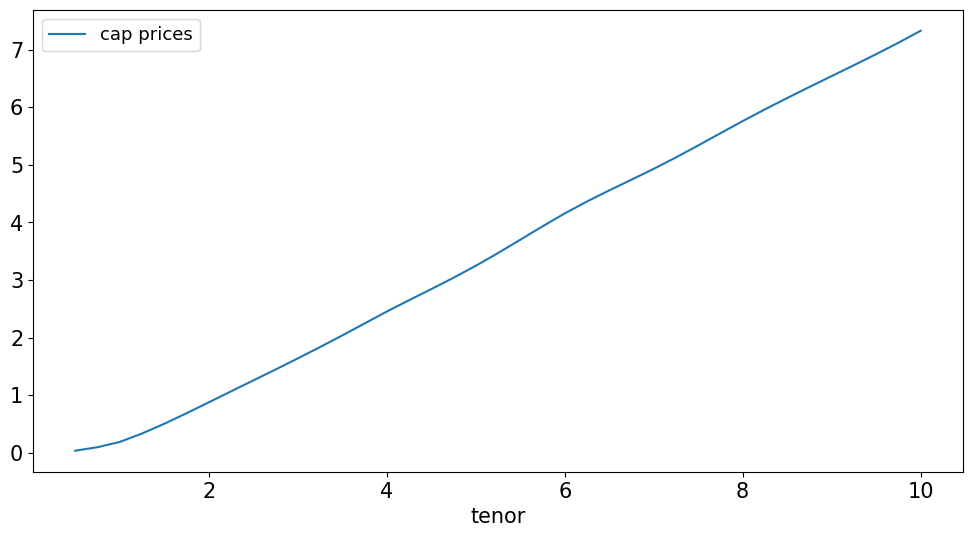

In [5]:
cap_prices[['cap prices']].plot()

## 1.2 Caplet Prices and Forward Volatilities

Using the cap prices, strip out the
* caplet prices
* forward volatility at $\tau$ which properly prices caplet $\tau$ using Black's formula.

List and plot the forward volatility versus the flat volatiltiy.

<Axes: xlabel='tenor'>

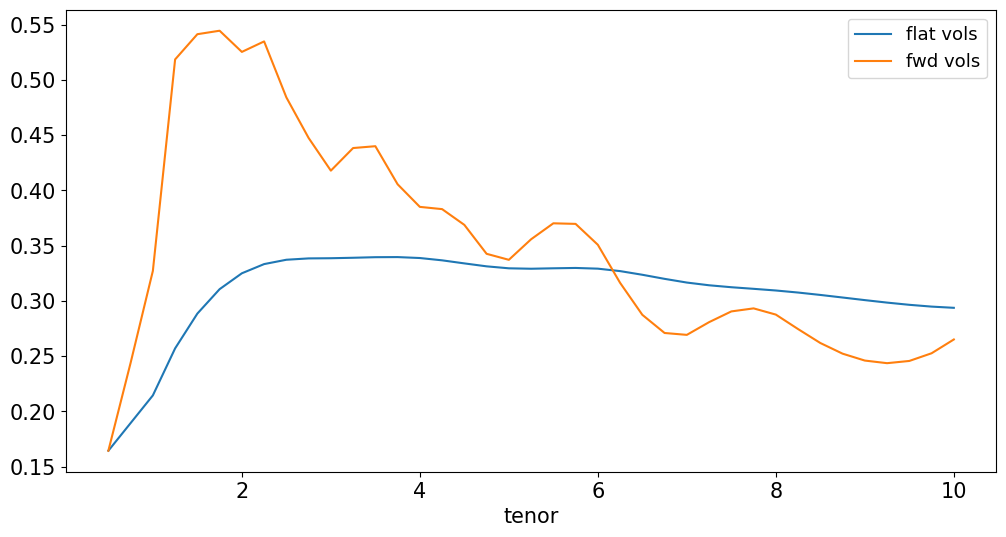

In [6]:
cap_prices[['flat vols', 'fwd vols']].plot()

## 1.3 Calibrate a BDT model 

Use data from the file `data/cap_curves_2024-02-16.xlsx` to calibrate the BDT model.
* Use the forward volatilities calculated in 1.2 to calibrate $\sigma$ at each step. 
* You do not have a forward volatility at $\tau=.25$ given there is no caplet there. For purposes of the BDT model, assume $\sigma_{.25}$ is equal to the forward volatility at the first estimated period, $t=0.50$. That is, use the first estimated forward vol (corresponding to $\tau=.50$ for both $t=.25$ and $t=.50$ in the BDT tree.    

Given these volatility parameters, calibrate the series of $\theta$ to fit the zero-coupon bond prices given by `discounts` (multiplied by 100).

**Display**
* the series of $\theta$ parameters.
* the tree of rates from $0\le t \le 10$.

In [7]:
def estimate_theta(sigmas, quotes_zeros, dt=None, T=None):
    """
    Estimates the theta values and constructs a rate tree based on the given parameters.

    Parameters:
    - sigmas (float or pd.Series): The volatility values for each time step.
    - quotes_zeros (pd.Series): The zero-coupon bond prices for each time step.
    - dt (float, optional): The time step size. If not provided, it is calculated based on the index of quotes_zeros.
    - T (float, optional): The maturity time. If not provided, it is set as the second-to-last index of quotes_zeros.

    Returns:
    - theta (pd.Series): The estimated theta values for each time step.
    - ratetree (pd.DataFrame): The constructed rate tree.

    Note:
    - The scale parameter is determined based on the mean of quotes_zeros.
    - The function uses the construct_rate_tree, incremental_BDT_pricing, and incrementBDTtree functions internally.
    """
    if dt is None:
        dt = quotes_zeros.index[1] - quotes_zeros.index[0]

    if T is None:
        T = quotes_zeros.index[-2]

    if quotes_zeros.mean() < 1:
        scale = 1
    else:
        scale = 100

    ratetree = construct_rate_tree(dt, T)
    theta = pd.Series(dtype=float, index=ratetree.columns, name='theta')
    dt = ratetree.columns[1] - ratetree.columns[0]

    if type(sigmas) is float:
        sigmas = pd.Series(sigmas, index=theta.index)

    for tsteps, t in enumerate(quotes_zeros.index):
        if tsteps == 0:
            ratetree.loc[0, 0] = -np.log(quotes_zeros.iloc[tsteps] / scale) / dt
        else:
            subtree = ratetree.iloc[:tsteps + 1, :tsteps + 1]
            wrapper = lambda theta: incremental_BDT_pricing(subtree, theta, sigmas.iloc[tsteps]).loc[0, 0] - quotes_zeros.iloc[tsteps] * 100 / scale

            theta.iloc[tsteps] = fsolve(wrapper, .5)[0]
            ratetree.iloc[:, tsteps] = incrementBDTtree(subtree, theta.iloc[tsteps], sigmas.iloc[tsteps]).iloc[:, tsteps]

            # print(f'Completed: {tsteps/len(quotes_zeros.index):.1%}')

    return theta, ratetree

def format_bintree(df, style='{:.2f}'):
    """
    Formats a binary tree DataFrame with a given style.

    Parameters:
    - df (pandas.DataFrame): The binary tree DataFrame to be formatted.
    - style (str, optional): The formatting style to be applied. Defaults to '{:.2f}'.

    Returns:
    - pandas.io.formats.style.Styler: The formatted binary tree DataFrame.
    """
    return df.style.format(style, na_rep='').format_index('{:.2f}', axis=1)

In [8]:
quotes = cap_curves['discounts']*100
sigmas = cap_curves['fwd vols']
sigmas.iloc[0] = sigmas.iloc[1]

theta, ratetree = estimate_theta(sigmas, quotes)

format_bintree(theta.to_frame().T, style='{:.2%}')

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00,7.25,7.50,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75
theta,,-11.18%,-25.39%,-34.70%,-72.14%,-42.25%,-35.67%,-25.10%,-33.93%,-2.57%,-0.04%,5.25%,-16.27%,-6.03%,14.39%,5.58%,-7.22%,5.69%,21.70%,14.22%,0.21%,-3.55%,-1.95%,3.13%,10.69%,15.30%,17.01%,15.88%,12.37%,10.00%,9.18%,9.99%,12.21%,14.12%,15.41%,16.07%,16.02%,15.15%,13.37%,10.55%


In [9]:
format_bintree(ratetree, style='{:.2%}')

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00,7.25,7.50,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,5.29%,5.58%,5.81%,6.05%,6.03%,6.54%,7.23%,8.19%,9.02%,10.67%,12.64%,15.13%,17.19%,20.06%,24.61%,29.39%,33.72%,39.71%,48.63%,58.71%,69.03%,80.87%,95.09%,112.34%,133.30%,158.08%,187.04%,220.72%,259.82%,305.65%,359.55%,422.96%,497.48%,584.71%,686.63%,805.62%,944.46%,1106.35%,1295.05%,1514.88%
1,,4.74%,4.93%,5.13%,5.12%,5.55%,6.13%,6.95%,7.65%,9.05%,10.72%,12.84%,14.58%,17.01%,20.87%,24.94%,28.60%,33.68%,41.26%,49.81%,58.56%,68.60%,80.66%,95.30%,113.08%,134.10%,158.67%,187.24%,220.41%,259.29%,305.02%,358.80%,422.02%,496.02%,582.48%,683.43%,801.20%,938.54%,1098.61%,1285.10%
2,,,4.00%,4.16%,4.15%,4.50%,4.98%,5.64%,6.21%,7.35%,8.70%,10.42%,11.84%,13.81%,16.94%,20.24%,23.22%,27.34%,33.49%,40.43%,47.53%,55.68%,65.48%,77.36%,91.79%,108.85%,128.79%,151.99%,178.90%,210.47%,247.58%,291.24%,342.56%,402.62%,472.80%,554.74%,650.34%,761.81%,891.75%,1043.12%
3,,,,3.24%,3.23%,3.50%,3.87%,4.38%,4.83%,5.71%,6.77%,8.10%,9.20%,10.74%,13.17%,15.74%,18.05%,21.26%,26.03%,31.43%,36.95%,43.29%,50.90%,60.14%,71.36%,84.62%,100.13%,118.16%,139.08%,163.62%,192.48%,226.42%,266.31%,313.01%,367.57%,431.27%,505.59%,592.25%,693.27%,810.95%
4,,,,,2.26%,2.45%,2.71%,3.07%,3.38%,4.00%,4.74%,5.68%,6.45%,7.52%,9.23%,11.02%,12.64%,14.89%,18.24%,22.02%,25.89%,30.33%,35.66%,42.13%,49.99%,59.28%,70.14%,82.77%,97.43%,114.62%,134.84%,158.61%,186.56%,219.27%,257.50%,302.12%,354.18%,414.89%,485.66%,568.10%
5,,,,,,1.69%,1.87%,2.12%,2.33%,2.76%,3.26%,3.91%,4.44%,5.18%,6.36%,7.59%,8.71%,10.26%,12.56%,15.17%,17.83%,20.89%,24.56%,29.02%,34.43%,40.83%,48.32%,57.02%,67.11%,78.95%,92.88%,109.26%,128.51%,151.04%,177.37%,208.11%,243.97%,285.79%,334.53%,391.32%
6,,,,,,,1.28%,1.45%,1.60%,1.89%,2.23%,2.68%,3.04%,3.55%,4.35%,5.20%,5.96%,7.02%,8.60%,10.38%,12.21%,14.30%,16.81%,19.86%,23.57%,27.95%,33.07%,39.03%,45.94%,54.05%,63.58%,74.79%,87.97%,103.39%,121.41%,142.45%,167.00%,195.63%,229.00%,267.87%
7,,,,,,,,1.00%,1.10%,1.30%,1.54%,1.84%,2.09%,2.44%,2.99%,3.57%,4.10%,4.83%,5.91%,7.13%,8.39%,9.83%,11.56%,13.65%,16.20%,19.21%,22.73%,26.82%,31.57%,37.15%,43.70%,51.40%,60.46%,71.06%,83.45%,97.91%,114.78%,134.45%,157.38%,184.10%
8,,,,,,,,,0.76%,0.90%,1.07%,1.28%,1.45%,1.70%,2.08%,2.49%,2.85%,3.36%,4.11%,4.96%,5.84%,6.84%,8.04%,9.50%,11.27%,13.37%,15.82%,18.66%,21.97%,25.85%,30.40%,35.76%,42.07%,49.44%,58.06%,68.12%,79.86%,93.55%,109.51%,128.09%


***

# 2. Pricing a Callable Bond with BDT

## Freddie Mac

The U.S. has many forms of *agency* debt in addition to *Treasury* debt. The largest of these *agency* issuers are the housing entities commonly referred to as Freddie Mac and Fannie Mae. While technically distinct from the U.S. Treasury, they are widely seen as having the full credit and backing of the Treasury--particularly after the bailouts of 2008.

Thus, we will examine this agency debt as (credit) risk-free, just like Treasury debt.

Consider the Freddie Mac bond with Bloomberg ID `COZD1131782`, CUSIP `3134H1TN3`.
* Issued 2024-02-16
* Matures 2034-02-21
* Semiannual coupons
* Coupon rate 6.00%

Note that these bonds are not a niche market. Just this particular bond was issued with \$15 billion face value.

## 2.1 Price the Freddie Mac Bond


Assume today is `2024-02-16`.
* The market price on this day is `$99.953`.
* Approximate the TTM (time-to-maturity) to be exactly 10 years.

Price this bond using the model calibrated from  data.
* Price it with the BDT model calibrated in the previous problem.
* Note that the coupons are paid semiannually whereas the tree steps are quarterly.

Report the tree of bond prices, emphasizing the current modeled price.

How does our modeled price compare to the market price?

In [10]:
def construct_bond_cftree(T, compound, cpn, cpn_freq=2, face=100):
    """
    Constructs a cashflow tree for a bond.

    Parameters:
    - T (float): Time to maturity of the bond.
    - compound (float): Compound interest rate per period.
    - cpn (float): Coupon rate of the bond.
    - cpn_freq (int, optional): Number of coupon payments per year. Default is 2.
    - face (float, optional): Face value of the bond. Default is 100.

    Returns:
    - cftree (DataFrame): Cashflow tree representing the bond's cashflows over time.
    """
    step = int(compound/cpn_freq)

    cftree = construct_rate_tree(1/compound, T)
    cftree.iloc[:,:] = 0
    cftree.iloc[:, -1:0:-step] = (cpn/cpn_freq) * face

    # final cashflow is accounted for in payoff function
    # drop final period cashflow from cashflow tree
    cftree = cftree.iloc[:-1,:-1]

    return cftree

def payoff_bond(r, dt, facevalue=100):
    """
    Calculates the price of a bond given the interest rate and time to maturity.

    Parameters:
    r (float): The interest rate.
    dt (float): The time to maturity.
    facevalue (float, optional): The face value of the bond. Default is 100.

    Returns:
    float: The price of the bond.
    """
    price = np.exp(-r * dt) * facevalue
    return price

def bintree_pricing(payoff=None, ratetree=None, undertree=None, cftree=None, dt=None, pstars=None, timing=None, cfdelay=False, style='european', Tamerican=0):
    """
    Calculates the pricing of a derivative using a binomial tree model.

    Parameters:
    - payoff (function): The payoff function of the derivative. Default is None.
    - ratetree (DataFrame): The interest rate tree. Default is None.
    - undertree (DataFrame): The underlying asset price tree. Default is None.
    - cftree (DataFrame): The cash flow tree. Default is None.
    - dt (float): The time step size. Default is None.
    - pstars (Series): The probabilities of up movement in the tree. Default is None.
    - timing (str): The timing of cash flows. Default is None.
    - cfdelay (bool): Whether to delay cash flows. Default is False.
    - style (str): The style of the derivative. Default is 'european'.
    - Tamerican (float): The time at which the derivative can be exercised for American style. Default is 0.

    Returns:
    - valuetree (DataFrame): The tree of derivative values.
    """
    
    if payoff is None:
        payoff = lambda r: 0
    
    if undertree is None:
        undertree = ratetree
        
    if cftree is None:
        cftree = pd.DataFrame(0, index=undertree.index, columns=undertree.columns)
        
    if pstars is None:
        pstars = pd.Series(.5, index=undertree.columns)

    if dt is None:
        dt = undertree.columns.to_series().diff().mean()
        dt = undertree.columns[1]-undertree.columns[0]
    
    if timing == 'deferred':
        cfdelay = True
    
    if dt<.25 and cfdelay:
        display('Warning: cfdelay setting only delays by dt.')
        
    valuetree = pd.DataFrame(dtype=float, index=undertree.index, columns=undertree.columns)

    for steps_back, t in enumerate(valuetree.columns[-1::-1]):
        if steps_back==0:                           
            valuetree[t] = payoff(undertree[t])
            if cfdelay:
                valuetree[t] *= np.exp(-ratetree[t]*dt)
        else:
            for state in valuetree[t].index[:-1]:
                val_avg = pstars[t] * valuetree.iloc[state,-steps_back] + (1-pstars[t]) * valuetree.iloc[state+1,-steps_back]
                
                if cfdelay:
                    cf = cftree.loc[state,t]
                else:                    
                    cf = cftree.iloc[state,-steps_back]
                
                valuetree.loc[state,t] = np.exp(-ratetree.loc[state,t]*dt) * (val_avg + cf)

            if style=='american':
                if t>= Tamerican:
                    valuetree.loc[:,t] = np.maximum(valuetree.loc[:,t],payoff(undertree.loc[:,t]))
        
    return valuetree

def construct_accint(timenodes, freq, cpn, cpn_freq=2, face=100):
    """
    Constructs the accrued interest for a bond at given time nodes.

    Parameters:
    timenodes (array-like): Time nodes at which to calculate accrued interest.
    freq (int): Number of times interest is compounded per year.
    cpn (float): Coupon rate of the bond.
    cpn_freq (int, optional): Number of times coupon is paid per year. Defaults to 2.
    face (float, optional): Face value of the bond. Defaults to 100.

    Returns:
    accint (pd.Series): Series containing the accrued interest at each time node.
    """
    mod = freq/cpn_freq
    cpn_pmnt = face * cpn/cpn_freq

    temp = np.arange(len(timenodes)) % mod
    # shift to ensure end is considered coupon (not necessarily start)
    temp = (temp - temp[-1] - 1) % mod
    temp = cpn_pmnt * temp.astype(float)/mod

    accint = pd.Series(temp,index=timenodes)

    return accint

In [11]:
FACE = 100
T = 10
compound = 4
cpn = 0.06
cpn_freq = 2

STRIKE = 100
CLEANCALL = True

dt = 1/compound
tsteps = int(T/dt)

wrapper_bond = lambda r: payoff_bond(r, dt, facevalue = FACE * (1 + cpn / cpn_freq))
payoff_call = lambda p: np.maximum(p - STRIKE, 0)

cftree = construct_bond_cftree(T, compound, cpn)
bondtree = bintree_pricing(payoff=wrapper_bond, ratetree=ratetree.iloc[:tsteps,:tsteps], cftree=cftree)
format_bintree(bondtree)


time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00,7.25,7.50,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,116.65,113.10,106.26,102.08,94.58,89.68,81.57,76.27,67.93,62.51,54.26,49.19,41.50,37.06,30.10,26.63,20.82,18.37,13.60,12.24,8.59,8.11,5.26,5.37,3.14,3.62,1.83,2.49,1.03,1.72,0.54,1.16,0.24,0.73,0.09,0.41,0.03,0.20,0.13,2.33
1,,123.30,117.11,113.56,106.68,102.36,94.75,89.85,81.77,76.45,68.13,62.81,54.67,49.59,41.82,37.40,30.51,26.93,20.97,18.48,13.75,12.31,8.58,7.98,5.10,5.13,2.93,3.36,1.63,2.23,0.86,1.49,0.42,0.96,0.18,0.58,0.08,0.36,0.38,4.15
2,,,126.43,123.56,117.37,113.76,106.83,102.58,95.07,90.24,82.27,77.16,69.05,63.82,55.68,50.72,43.09,38.62,31.61,28.02,22.12,19.53,14.65,13.02,9.15,8.39,5.43,5.34,3.09,3.42,1.69,2.21,0.88,1.43,0.44,0.93,0.29,0.78,1.14,7.59
3,,,,131.84,126.33,123.44,117.26,113.76,107.00,102.88,95.56,91.01,83.34,78.43,70.44,65.45,57.61,52.72,45.09,40.72,33.88,30.28,24.25,21.49,16.44,14.62,10.60,9.65,6.54,6.26,3.88,4.05,2.27,2.69,1.39,1.95,1.19,2.14,3.40,13.56
4,,,,,133.50,131.27,125.79,123.03,117.03,113.71,107.16,103.37,96.40,92.13,84.69,80.14,72.56,67.81,60.11,55.52,48.22,44.04,37.23,33.60,27.51,24.68,19.53,17.58,13.39,12.26,8.95,8.52,6.01,6.13,4.37,5.02,4.27,6.25,9.45,24.89
5,,,,,,137.25,132.36,130.25,124.93,122.34,116.54,113.51,107.29,103.79,97.08,93.20,86.20,81.96,74.65,70.31,63.09,58.85,51.79,47.80,41.15,37.67,31.71,28.97,23.85,21.90,17.69,16.57,13.31,13.04,10.84,11.62,11.12,14.44,19.81,38.72
6,,,,,,,137.31,135.72,130.95,128.98,123.83,121.48,115.96,113.19,107.22,104.07,97.77,94.22,87.54,83.75,76.97,73.08,66.23,62.35,55.64,52.01,45.73,42.61,36.96,34.51,29.68,28.06,24.24,23.67,21.19,22.16,22.00,26.48,33.21,52.72
7,,,,,,,,139.78,135.46,133.98,129.35,127.56,122.63,120.50,115.18,112.71,107.09,104.25,98.25,95.12,88.94,85.62,79.25,75.80,69.40,66.02,59.83,56.74,50.99,48.41,43.33,41.51,37.42,36.73,34.12,35.25,35.28,40.31,47.16,65.01
8,,,,,,,,,138.79,137.69,133.47,132.13,127.67,126.05,121.29,119.39,114.35,112.14,106.78,104.29,98.73,96.03,90.25,87.36,81.46,78.53,72.70,69.92,64.36,61.94,56.91,55.14,51.00,50.32,47.63,48.81,48.77,53.70,59.68,74.78


In [12]:
accint = construct_accint(bondtree.columns.values, compound, cpn)
cleantree = np.maximum(bondtree.subtract(accint,axis=1),0)

format_bintree(cleantree)

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00,7.25,7.50,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,116.65,111.60,106.26,100.58,94.58,88.18,81.57,74.77,67.93,61.01,54.26,47.69,41.50,35.56,30.10,25.13,20.82,16.87,13.60,10.74,8.59,6.61,5.26,3.87,3.14,2.12,1.83,0.99,1.03,0.22,0.54,0.00,0.24,0.00,0.09,0.00,0.03,0.00,0.13,0.83
1,,121.80,117.11,112.06,106.68,100.86,94.75,88.35,81.77,74.95,68.13,61.31,54.67,48.09,41.82,35.90,30.51,25.43,20.97,16.98,13.75,10.81,8.58,6.48,5.10,3.63,2.93,1.86,1.63,0.73,0.86,0.00,0.42,0.00,0.18,0.00,0.08,0.00,0.38,2.65
2,,,126.43,122.06,117.37,112.26,106.83,101.08,95.07,88.74,82.27,75.66,69.05,62.32,55.68,49.22,43.09,37.12,31.61,26.52,22.12,18.03,14.65,11.52,9.15,6.89,5.43,3.84,3.09,1.92,1.69,0.71,0.88,0.00,0.44,0.00,0.29,0.00,1.14,6.09
3,,,,130.34,126.33,121.94,117.26,112.26,107.00,101.38,95.56,89.51,83.34,76.93,70.44,63.95,57.61,51.22,45.09,39.22,33.88,28.78,24.25,19.99,16.44,13.12,10.60,8.15,6.54,4.76,3.88,2.55,2.27,1.19,1.39,0.45,1.19,0.64,3.40,12.06
4,,,,,133.50,129.77,125.79,121.53,117.03,112.21,107.16,101.87,96.40,90.63,84.69,78.64,72.56,66.31,60.11,54.02,48.22,42.54,37.23,32.10,27.51,23.18,19.53,16.08,13.39,10.76,8.95,7.02,6.01,4.63,4.37,3.52,4.27,4.75,9.45,23.39
5,,,,,,135.75,132.36,128.75,124.93,120.84,116.54,112.01,107.29,102.29,97.08,91.70,86.20,80.46,74.65,68.81,63.09,57.35,51.79,46.30,41.15,36.17,31.71,27.47,23.85,20.40,17.69,15.07,13.31,11.54,10.84,10.12,11.12,12.94,19.81,37.22
6,,,,,,,137.31,134.22,130.95,127.48,123.83,119.98,115.96,111.69,107.22,102.57,97.77,92.72,87.54,82.25,76.97,71.58,66.23,60.85,55.64,50.51,45.73,41.11,36.96,33.01,29.68,26.56,24.24,22.17,21.19,20.66,22.00,24.98,33.21,51.22
7,,,,,,,,138.28,135.46,132.48,129.35,126.06,122.63,119.00,115.18,111.21,107.09,102.75,98.25,93.62,88.94,84.12,79.25,74.30,69.40,64.52,59.83,55.24,50.99,46.91,43.33,40.01,37.42,35.23,34.12,33.75,35.28,38.81,47.16,63.51
8,,,,,,,,,138.79,136.19,133.47,130.63,127.67,124.55,121.29,117.89,114.35,110.64,106.78,102.79,98.73,94.53,90.25,85.86,81.46,77.03,72.70,68.42,64.36,60.44,56.91,53.64,51.00,48.82,47.63,47.31,48.77,52.20,59.68,73.28


## 2.2 Callable Bond

One important difference between Treasury debt and this bond is that this bond is **callable**
* Note that the holder of the bond is short this call option; (the issuer has the optionality.) 

#### Style
* (approximately) American style
* called only on quarterly dates, not any date
* since our tree is quarterly, this means callable on any date on our tree.

#### Strike
* Strike is 100.
* The strike is based on the **clean** price of the bond, meaning the price which does not account for accrued interest.
    * In pricing the bond in the previous problem, you should have considered the accrued coupons, or dirty prices.
    * But in analyzing the option, you must consider its moneyness and payoff based on the clean price.

### Pricing
Use the BDT model to price this implicit American call option and the resulting callable bond.
* Note that the price of the callable bond is your answer to the previous question minus this American option.
* How close is the modeled price to the market quoted price now that you are accounting for the short embedded option? 

Does the price of the callable bond ever get above \$100?

In [13]:
undertree = cleantree #since Clean call
    
calltree = bintree_pricing(payoff=payoff_call, ratetree=ratetree.iloc[:tsteps,:tsteps], undertree= undertree, style='american')
format_bintree(calltree)

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00,7.25,7.50,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,17.71,14.06,10.78,8.02,5.78,4.02,2.70,1.75,1.09,0.64,0.36,0.19,0.10,0.04,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,,21.82,17.74,13.86,10.50,7.71,5.47,3.75,2.48,1.58,0.96,0.56,0.31,0.16,0.08,0.03,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,,,26.43,22.06,17.57,13.56,10.18,7.35,5.15,3.48,2.27,1.42,0.84,0.48,0.25,0.13,0.06,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,,,,30.34,26.33,21.94,17.26,13.25,9.77,6.97,4.82,3.22,2.06,1.26,0.73,0.40,0.21,0.10,0.04,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,,,,,33.50,29.77,25.79,21.53,17.03,12.80,9.33,6.59,4.51,2.96,1.86,1.11,0.63,0.34,0.16,0.07,0.03,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,,,,,,35.75,32.36,28.75,24.93,20.84,16.54,12.29,8.85,6.21,4.17,2.69,1.66,0.97,0.53,0.27,0.13,0.05,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,,,,,,,37.31,34.22,30.95,27.48,23.83,19.98,15.96,11.69,8.41,5.79,3.82,2.42,1.45,0.83,0.44,0.21,0.09,0.03,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,,,,,,,,38.28,35.46,32.48,29.35,26.06,22.63,19.00,15.18,11.21,7.91,5.34,3.47,2.15,1.26,0.69,0.35,0.16,0.06,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,,,,,,,,,38.79,36.19,33.47,30.63,27.67,24.55,21.29,17.89,14.35,10.64,7.35,4.89,3.11,1.88,1.07,0.56,0.26,0.11,0.04,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [14]:
QUOTE_CALLABLE_CLEAN = 99.953
num_accrued = int((T*compound) %cpn_freq)
quote_callable_dirty = QUOTE_CALLABLE_CLEAN + num_accrued * (cpn/compound)*FACE

callablebondtree = bondtree - calltree
model_price_dirty = callablebondtree.iloc[0,0]
model_price_clean = model_price_dirty - accint.iloc[0]

prices = pd.DataFrame({'clean':[QUOTE_CALLABLE_CLEAN, model_price_clean], 'dirty':[quote_callable_dirty, model_price_dirty]}, index=['market quote','model'])
prices.style.format('{:.2f}')

,clean,dirty
market quote,99.95,99.95
model,98.94,98.94


## 2.3 Exercising the Option

Show a heatmap of the nodes in which the American bond is exercised.

Is it exercised every time it is in-the-money?

In [15]:
def exercise_decisions(payoff, undertree, derivtree):
    """
    Determines the exercise decisions for a derivative based on the payoff function, the underlying tree, and the derivative tree.

    Parameters:
    - payoff (function): The payoff function that calculates the derivative's payoff based on the underlying tree.
    - undertree (array-like): The underlying tree.
    - derivtree (array-like): The derivative tree.

    Returns:
    - exer (array-like): A boolean array indicating the exercise decisions for the derivative.
    """
    exer = (derivtree == payoff(undertree)) & (derivtree > 0)
    return exer

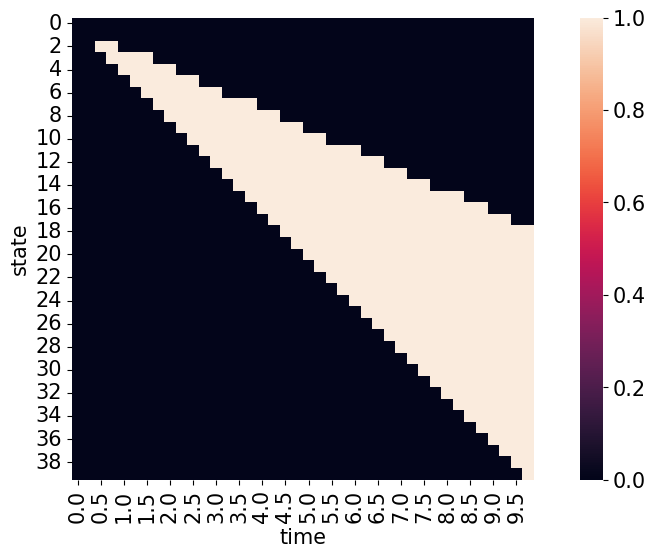

In [16]:
decision_matrix = exercise_decisions(payoff_call, undertree, calltree) #exercised 

sns.heatmap(decision_matrix,square=True);


<Axes: xlabel='time', ylabel='state'>

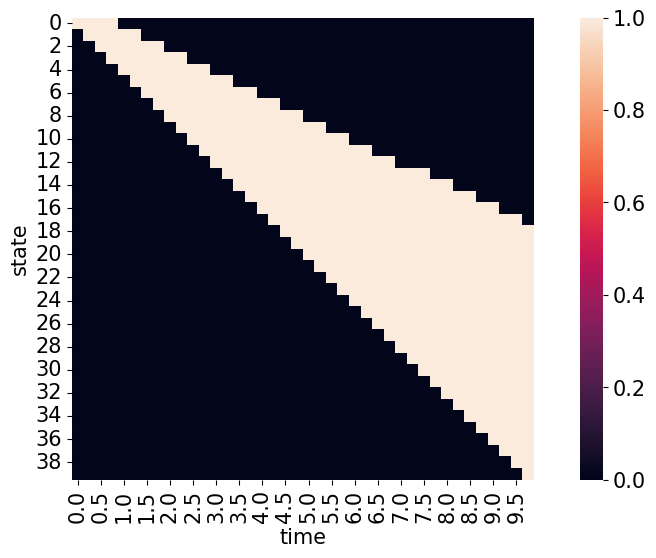

In [18]:
sns.heatmap(undertree > STRIKE, square=True) #in the money

The American option is not exercised every time it is in the money cf. first nodes. 

***

# 3. Option Adjusted Spread

*This section is optional. No need to submit it, but we will likely discuss it in class.*

## 3.1 Calculate the OAS

The **option adjusted spread** is the spread one would need to add to the spot curve, (the discounts), to get the modeled price to match the market price of the derivative. That is, how many bps would you need to add or subtract to all the spot rates in order to perfectly price this callable bond? 

* Ignore the effect of the parallel shift in rates on the forward vols. (No need to recalculate section 1.) 

* Use the parallel shifts to recalibrate the $\theta$ parameters in the BDT tree. 

Report the OAS needed to add (or subtract) in a parallel shift in spot to correctly model the callable bond.

#### Note:
This **OAS** is a common way to quote whether a derivative seems to be undervalued (positive OAS) or overvalued (negative OAS.) Of course, the OAS is dependent on our modeling choices, so it could also indicate the model is bad.

## 3.2 Convexity

Continue with parallel shifts of the (present, market quoted) yield curve. 
* Plot the relationship between the value of the callable bond as the spot curve shifts higher and lower.
* Do you see convexity in this relationship?

***